In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('/home/growlt259/Desktop/Inventory_Prediction_Retail_Market.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Promotion Code,Employee ID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,A,62.0
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,A,46.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,C,13.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,B,22.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,C,79.0


In [3]:
data['sales'] = data['Quantity'] * data['UnitPrice']
data['Date'] = data['InvoiceDate'].dt.date
# data = data[data['Quantity'] > 0]
data.drop(["Promotion Code", "Employee ID"], axis = 1, inplace=True)
data.drop_duplicates(inplace=True)
data.shape

(536643, 10)

In [4]:
desc_to_rmv = ['DOT', 'POST', 'S', 'AMAZONFEE', 'BANK CHARGES', 'CRUK']

In [5]:
data = data[~(data['StockCode'].isin(desc_to_rmv))]
data.shape

(534528, 10)

In [6]:
data = data[~((data['sales'] > 1000) | (data['sales'] < -1000))]

In [7]:
data.set_index('InvoiceDate', inplace=True)
daily_sales = data.sales.resample('D').sum()
daily_sales

InvoiceDate
2010-12-01    54395.50
2010-12-02    41991.32
2010-12-03    42155.90
2010-12-04        0.00
2010-12-05    30559.63
                ...   
2011-12-05    80014.34
2011-12-06    51416.62
2011-12-07    55000.65
2011-12-08    66851.77
2011-12-09    29305.57
Freq: D, Name: sales, Length: 374, dtype: float64

<Axes: xlabel='InvoiceDate'>

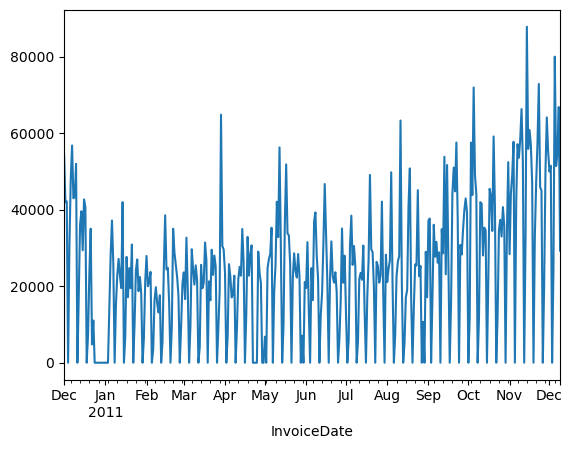

In [8]:
daily_sales.plot()

<Axes: xlabel='InvoiceDate'>

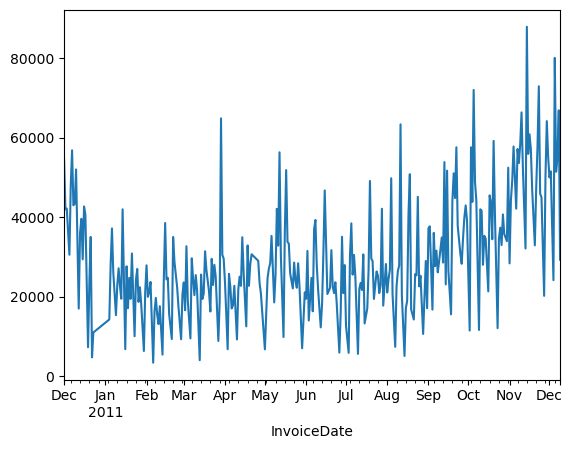

In [9]:
daily_sales.replace(0, np.nan, inplace=True)
daily_sales.interpolate(method = 'linear', inplace=True)
daily_sales.plot()

In [10]:
daily_sales = pd.DataFrame(daily_sales)
daily_sales.reset_index(inplace = True)
daily_sales.head()

,InvoiceDate,sales
0,2010-12-01,54395.500
1,2010-12-02,41991.320
2,2010-12-03,42155.900
3,2010-12-04,36357.765
4,2010-12-05,30559.630


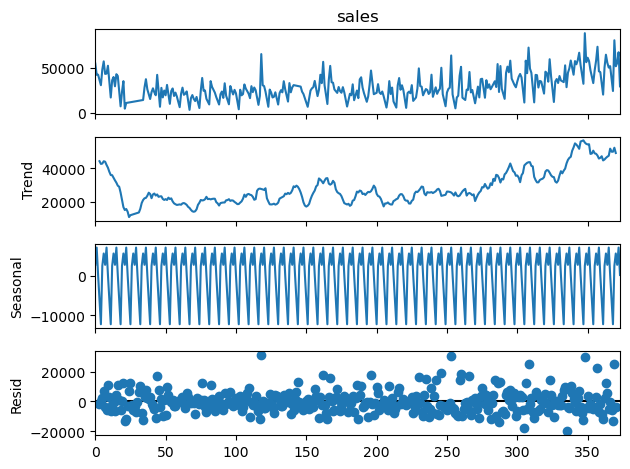

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(daily_sales['sales'], model='additive', period=7)
figure = result.plot()
plt.show()

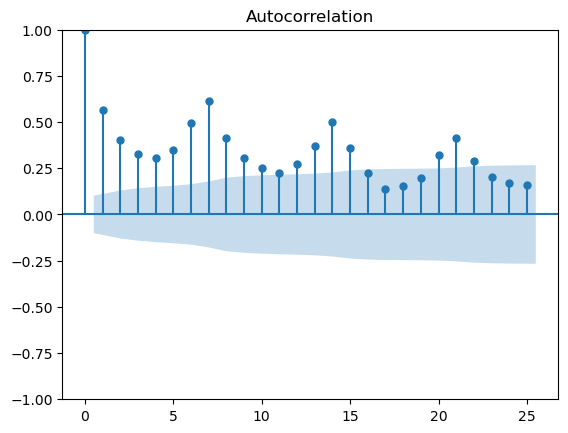

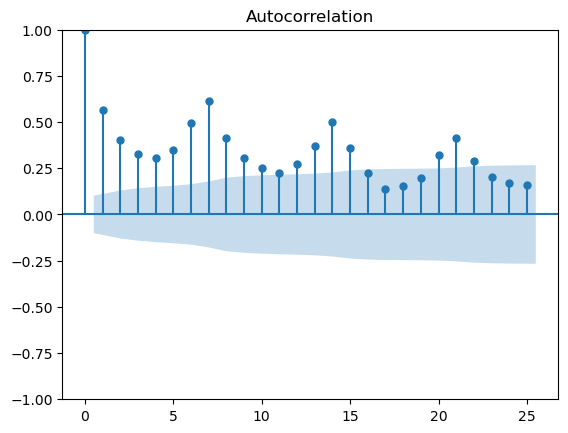

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf

plot_acf(daily_sales['sales'], lags=25)

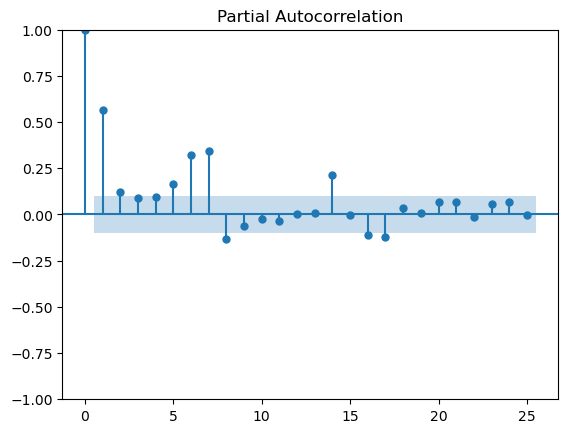

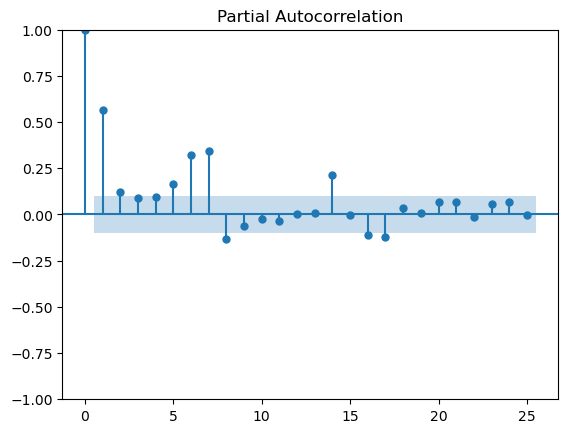

In [13]:
plot_pacf(daily_sales['sales'], lags=25)

# LSTM

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

daily_sales.set_index('InvoiceDate', inplace=True)

df = daily_sales.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define window size (number of time steps to look back)
window_size = 14

# Function to create dataset with input features and target variable
def create_dataset(df, window_size):
    X, Y = [], []
    for i in range(len(df) - window_size):
        X.append(df[i:(i + window_size)])
        Y.append(df[i + window_size])
    return np.array(X), np.array(Y)

# Create dataset
X, Y = create_dataset(scaled_data, window_size)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=30, shuffle=False)

# Reshape data for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1))))
model.add(Bidirectional(LSTM(units=128)))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))

# Compile model
model.compile(optimizer='Adam', loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

# Evaluate model
loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)

2024-07-13 22:59:45.091480: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-13 22:59:45.098708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 22:59:45.108407: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 22:59:45.108431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-13 22:59:45.115343: I tensorflow/core/platform/cpu_feature_gua

Epoch 1/100


/home/growlt259/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.0541 - val_loss: 0.0561
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0190 - val_loss: 0.0540
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0180 - val_loss: 0.0368
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0167 - val_loss: 0.0447
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0171 - val_loss: 0.0367
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0175 - val_loss: 0.0388
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0167 - val_loss: 0.0518
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0179 - val_loss: 0.0370
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0168 - val_loss: 0.0429
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0177 - val_loss: 0.0390
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0161 - val_loss: 0.0400
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.

Epoch 69/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0130 - val_loss: 0.0323
Epoch 70/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0130 - val_loss: 0.0348
Epoch 71/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0115 - val_loss: 0.0333
Epoch 72/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0122 - val_loss: 0.0325
Epoch 73/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0115 - val_loss: 0.0318
Epoch 74/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0118 - val_loss: 0.0330
Epoch 75/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0120 - val_loss: 0.0379
Epoch 76/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0126 - val_loss: 0.0328
Epoch 77/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0103 - val_loss: 0.0375
Epoch 78/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0112 - val_loss: 0.0292
Epoch 79/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0116 - val_loss: 0.0379
Epoch 80/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [16]:
y_test = scaler.inverse_transform(y_test)
print(y_test)

[[66323.33 ]
 [52509.73 ]
 [42320.105]
 [32130.48 ]
 [87842.64 ]
 [55887.   ]
 [60826.82 ]
 [57132.83 ]
 [46976.86 ]
 [39948.38 ]
 [32919.9  ]
 [47043.61 ]
 [57556.   ]
 [72882.9  ]
 [45889.25 ]
 [45015.61 ]
 [32627.7  ]
 [20239.79 ]
 [50186.81 ]
 [64129.8  ]
 [55231.37 ]
 [49979.49 ]
 [51502.96 ]
 [37845.39 ]
 [24187.82 ]
 [80014.34 ]
 [51416.62 ]
 [55000.65 ]
 [66851.77 ]
 [29305.57 ]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


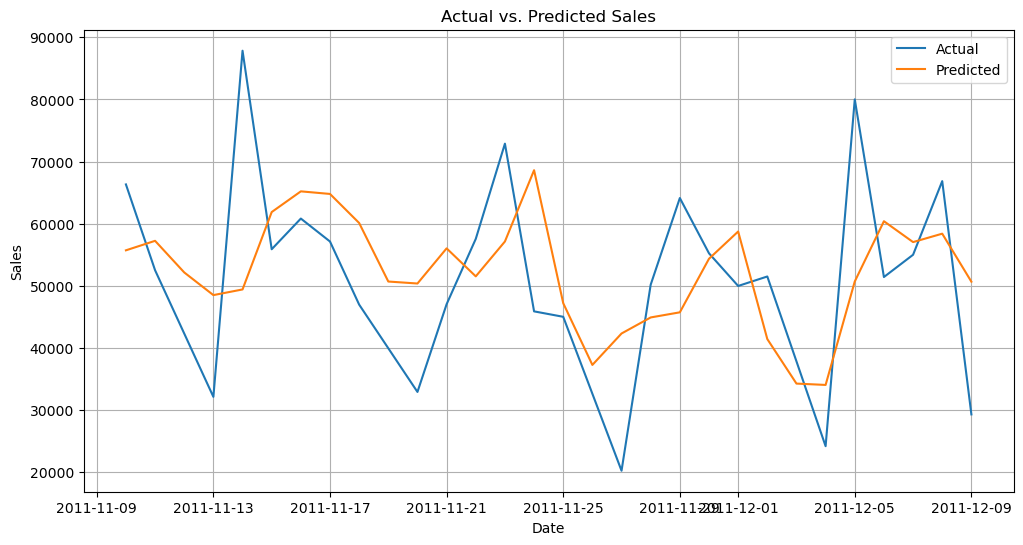

In [17]:
predictions = model.predict(X_test)

# Inverse transform predictions and actual values
predictions = scaler.inverse_transform(predictions)

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index[-len(y_test):], y_test, label='Actual')
plt.plot(daily_sales.index[-len(predictions):], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Sales')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
from sklearn.metrics import r2_score, mean_absolute_error
print(r2_score(y_test, predictions))
print(mean_absolute_error(y_test, predictions))

0.1363475650558914
11623.982854166668


In [19]:
y_test.mean()

50390.850833333345